1. Data Collection

1.1 Import Library

In [16]:
#import library

import numpy as np # type: ignore
import pandas as pd
import seaborn as sns
import yfinance as yf
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer # type: ignore
from sklearn.decomposition import LatentDirichletAllocation

1.2 Load dataset

In [17]:
#load news analys rating dataset
news_data = pd.read_csv("../data/raw_analyst_ratings.csv")
news_data.head()

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [18]:
# Load stock data
stock_data = pd.read_csv("../data/GOOG_historical_data.csv")
stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
0,2004-08-19,2.490664,2.591785,2.390042,2.499133,2.496292,897427216,0.0,0.0
1,2004-08-20,2.515820,2.716817,2.503118,2.697639,2.694573,458857488,0.0,0.0
2,2004-08-23,2.758411,2.826406,2.716070,2.724787,2.721690,366857939,0.0,0.0
3,2004-08-24,2.770615,2.779581,2.579581,2.611960,2.608991,306396159,0.0,0.0
4,2004-08-25,2.614201,2.689918,2.587302,2.640104,2.637103,184645512,0.0,0.0


Date Conversion

In [19]:
# Convert 'date' column in news data to datetime
news_data['date'] = news_data['date'].str.slice(0, 19)  
news_data['date'] = pd.to_datetime(news_data['date']).dt.date

# Convert 'Date' column in stock data to datetime
stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date

In [20]:
# Filter stock data to match the date range of news data
start_date = news_data['date'].min()
end_date = news_data['date'].max()
stock_data = stock_data[(stock_data['Date'] >= start_date) & (stock_data['Date'] <= end_date)]


In [21]:
# Function to calculate sentiment score using TextBlob
def get_sentiment_score(text):
    return TextBlob(text).sentiment.polarity

# Apply sentiment analysis to the headlines
news_data['sentiment_score'] = news_data['headline'].apply(get_sentiment_score)

# Categorize sentiment
def categorize_sentiment(score):
    if score > 0.1:
        return 'Positive'
    elif score < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

news_data['sentiment'] = news_data['sentiment_score'].apply(categorize_sentiment)


In [22]:
# Calculate daily returns for stock
stock_data['daily_return'] = stock_data['Close'].pct_change()

# Rename columns to avoid conflicts
news_data.rename(columns={'date': 'Date'}, inplace=True)

In [23]:
# Merge news data with stock data on Date
combined_data = pd.merge(stock_data, news_data, on='Date', how='left')


In [24]:
# Aggregate sentiment scores by date
daily_sentiment = combined_data.groupby('Date')['sentiment_score'].mean().reset_index()
daily_sentiment.rename(columns={'sentiment_score': 'average_sentiment_score'}, inplace=True)


In [25]:
# Merge aggregated sentiment with combined data
final_data = pd.merge(combined_data, daily_sentiment, on='Date', how='left')
final_data = final_data[['Date', 'average_sentiment_score', 'Close', 'daily_return']]
final_data.head()

,Date,average_sentiment_score,Close,daily_return
0,2009-02-17,NaN,8.534511,NaN
1,2009-02-18,NaN,8.794785,0.030497
2,2009-02-19,NaN,8.534012,-0.029651
3,2009-02-20,NaN,8.628907,0.011120
4,2009-02-23,NaN,8.220687,-0.047308


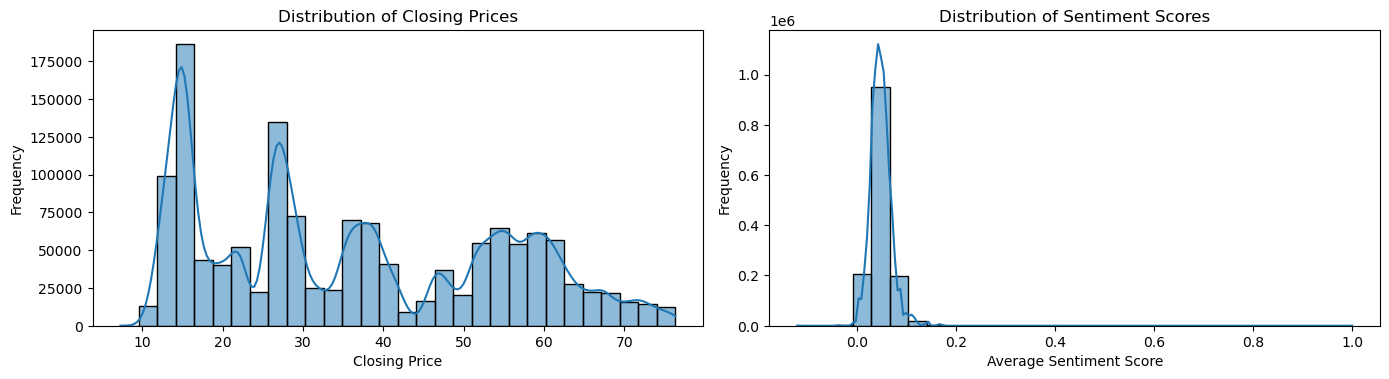

In [26]:
# Plot distributions
plt.figure(figsize=(14, 7))

# Distribution of Closing Prices
plt.subplot(2, 2, 1)
sns.histplot(final_data['Close'], kde=True, bins=30)
plt.title('Distribution of Closing Prices')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')

# Distribution of Sentiment Scores
plt.subplot(2, 2, 2)
sns.histplot(final_data['average_sentiment_score'], kde=True, bins=30)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [27]:
# Calculate correlation between sentiment and daily return
correlation_return = final_data[['average_sentiment_score', 'daily_return']].corr().iloc[0, 1]
print(f"Correlation between sentiment and daily return: {correlation_return}")


Correlation between sentiment and daily return: 0.1077430391229521


In [28]:
# Calculate correlation between sentiment and closing price
correlation_close = final_data[['average_sentiment_score', 'Close']].corr().iloc[0, 1]
print(f"Correlation between sentiment and closing price: {correlation_close}")


Correlation between sentiment and closing price: -0.22182295066290342


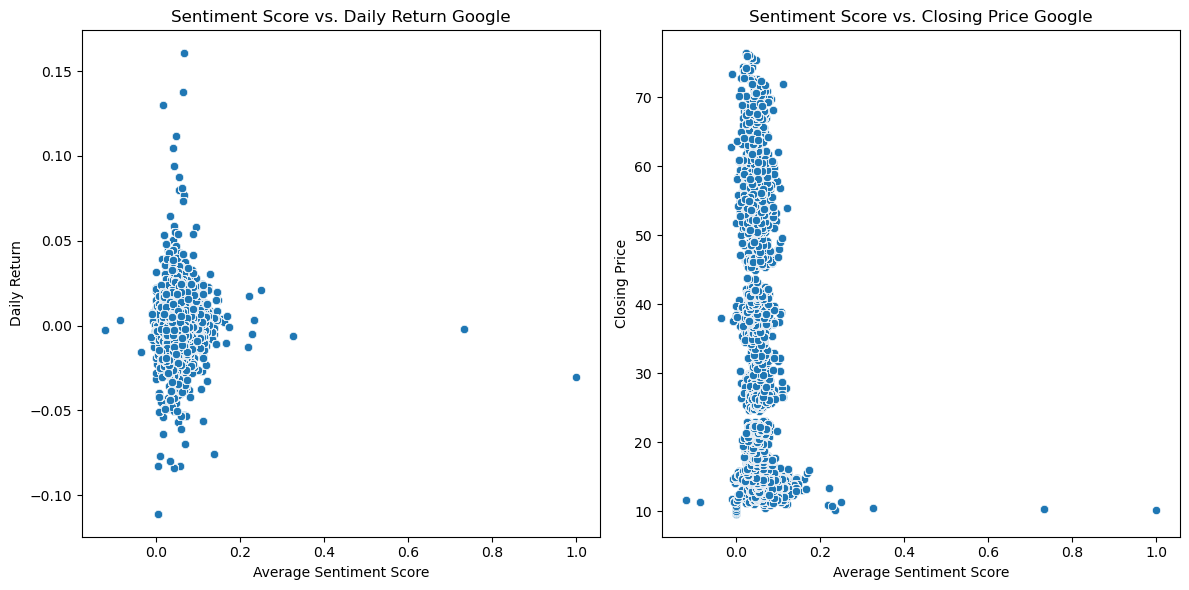

In [29]:
# Scatter plot for sentiment score vs. daily return
plt.figure(figsize=(12, 6))

# Sentiment score vs. daily return
plt.subplot(1, 2, 1)
sns.scatterplot(data=final_data, x='average_sentiment_score', y='daily_return')
plt.title('Sentiment Score vs. Daily Return Google')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Daily Return')

# Sentiment score vs. closing price
plt.subplot(1, 2, 2)
sns.scatterplot(data=final_data, x='average_sentiment_score', y='Close')
plt.title('Sentiment Score vs. Closing Price Google')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Closing Price')

plt.tight_layout()
plt.show()

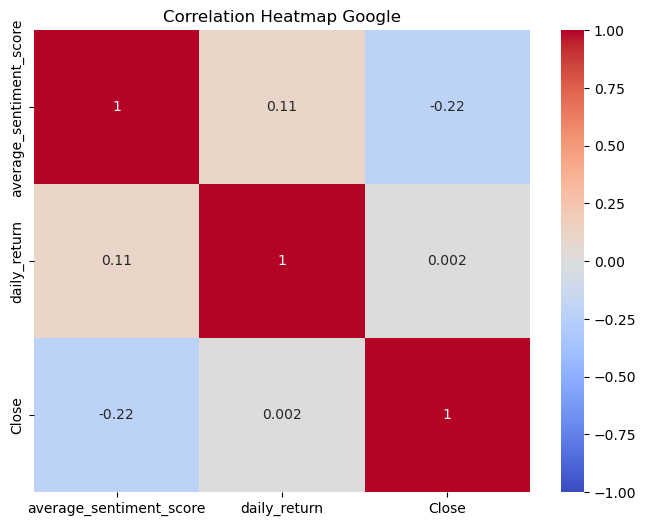

In [30]:
# Compute correlation matrix
correlation_matrix = final_data[['average_sentiment_score', 'daily_return', 'Close']].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap Google')
plt.show()